In [ ]:
'''
v2. Clear up code.
'''

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout

2022-12-09 00:21:13.237488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
set_style("whitegrid")

## Load data

In [4]:
pwd

'/Users/ziyuan/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/Machine_Learning/Erdos_Bootcamp/Project/modeling/modeling'

In [5]:
apple_raw=pd.read_csv('../../Dataset/merge_data_all_factor.csv')

In [6]:
apple_raw["Date"] = pd.to_datetime(apple_raw["Date"])

In [7]:
apple_raw

,Date,Close,Volume,Dow_Jones,SP500,Gross_Profit,ROE,PE_ratio,PS_ratio,tnote,tbill,Fed_rate,GDP,GDP_growth,CPI
0,2012-11-12,19.386786,515802000,12815.08,1380.03,14401,0.40,12.93,3.45,1.61,0.18,0.16,16420.386,2.280688,231.249
1,2012-11-13,19.389286,532949200,12756.18,1374.53,14401,0.40,12.93,3.45,1.59,0.18,0.16,16420.386,2.280688,231.249
2,2012-11-14,19.174286,477170400,12570.95,1355.49,14401,0.40,12.93,3.45,1.59,0.18,0.16,16420.386,2.280688,231.249
3,2012-11-15,18.772142,789910800,12542.38,1353.33,14401,0.40,12.93,3.45,1.58,0.17,0.16,16420.386,2.280688,231.249
4,2012-11-16,18.845715,1266893600,12588.31,1359.88,14401,0.40,12.93,3.45,1.58,0.16,0.16,16420.386,2.280688,231.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2523,2022-11-18,151.289993,74794600,33745.69,3992.93,38095,1.61,22.58,5.74,3.82,4.74,3.83,25663.289,1.800000,298.062
2524,2022-11-21,148.009995,58724100,33700.28,3992.93,38095,1.61,22.58,5.74,3.83,4.75,3.83,25663.289,1.800000,298.062
2525,2022-11-22,150.179993,51804100,34098.10,3992.93,38095,1.61,22.58,5.74,3.76,4.79,3.83,25663.289,1.800000,298.062
2526,2022-11-23,151.070007,58301400,34194.06,3992.93,38095,1.61,22.58,5.74,3.71,4.75,3.83,25663.289,1.800000,298.062


### Train-test split

In [8]:
train_split_ratio=0.75

In [9]:
# split dataset into train and test
len_total=apple_raw.shape[0]
len_train=int(len_total*train_split_ratio)
len_test = len_total - len_train
print(f"len_total:{len_total}", f"len_train:{len_train}", f"len_test:{len_total - len_train}")

len_total:2528 len_train:1896 len_test:632


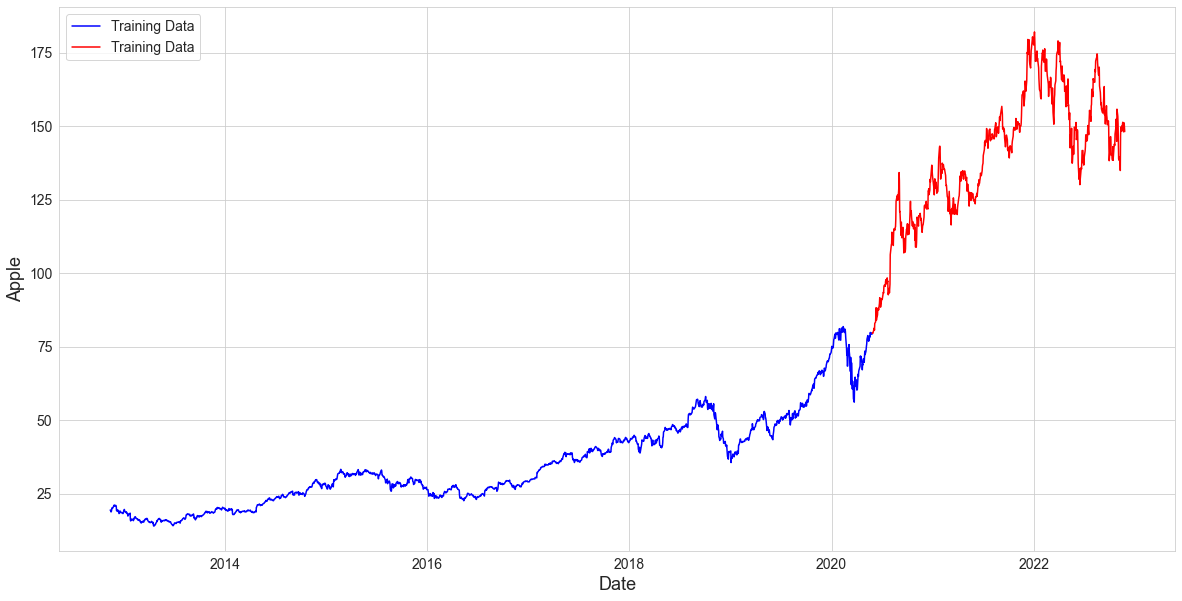

In [10]:
plt.figure(figsize=(20,10))


plt.plot(apple_raw.Date[:len_train], 
         apple_raw.Close[:len_train],
         'b',
         label="Training Data")

plt.plot(apple_raw.Date[len_train:], 
         apple_raw.Close[len_train:],
         'r',
         label="Training Data")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Apple", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=2)

plt.show()

In [11]:
# CPI, ROE, Volumn
feature_list = ['Close','ROE','PE_ratio','PS_ratio','Gross_Profit','SP500','Dow_Jones','CPI','GDP']

In [12]:
# pick the "Close" column
# need to reshape as (len, 1)
apple_raw_all = np.array(apple_raw[feature_list].iloc[:])
apple_raw_train = np.array(apple_raw[feature_list].iloc[:len_train])
apple_raw_test = np.array(apple_raw[feature_list].iloc[len_train:])

In [13]:
[np.shape(apple_raw_all), np.shape(apple_raw_train), np.shape(apple_raw_test)]

[(2528, 9), (1896, 9), (632, 9)]

### Scaling and transformation

In [14]:
scale = MinMaxScaler(feature_range = (0,1))

apple_raw_train_scaled = scale.fit_transform(apple_raw_train)
apple_raw_test_scaled = scale.fit_transform(apple_raw_test)

In [30]:
# scale = MinMaxScaler(feature_range = (0,1))

# apple_raw_scaled = scale.fit_transform(apple_raw_all)
# apple_raw_train_scaled = apple_raw_scaled[:len_train]
# apple_raw_test_scaled = apple_raw_scaled[len_train:]

In [15]:
# set window, use previous __ days as input to calculate the next day output
window = 45

In [16]:
x_train = []
y_train = []

for i in range(window, len_train):
    x_train.append(apple_raw_train_scaled[i-window:i, :])  # every x_train[i] is an array of len window=60
    y_train.append(apple_raw_train_scaled[i,:])            # every y_train[i] is a number of len 1
    
x_train,y_train = np.array(x_train),np.array(y_train)

In [17]:
# reshape for LSTM input as (len of training set,  len of each input, len of each output)
# each timestep is a feature tensor
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [18]:
x_train.shape

(1851, 45, 9)

In [19]:
y_train.shape

(1851, 9)

In [20]:
# do the same for x_test
x_test = []

for i in range(window, len_test):
    x_test.append(apple_raw_test_scaled[i-window:i, :])
    
x_test = np.array(x_test)

In [21]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], x_test.shape[2]))

In [22]:
[x_test.shape, len_test]

[(587, 45, 9), 632]

In [23]:
apple_raw_train_scaled

array([[0.08016338, 0.31428571, 0.30567376, ..., 0.01603265, 0.0010077 ,
        0.        ],
       [0.08020022, 0.31428571, 0.30567376, ..., 0.01256979, 0.0010077 ,
        0.        ],
       [0.07703159, 0.31428571, 0.30567376, ..., 0.0016797 , 0.0010077 ,
        0.        ],
       ...,
       [0.9618658 , 1.        , 0.77801418, ..., 0.70149403, 0.88976463,
        0.60844801],
       [0.96938213, 1.        , 0.77801418, ..., 0.70096725, 0.88976463,
        0.60844801],
       [0.96142368, 1.        , 0.77801418, ..., 0.73212421, 0.88976463,
        0.60844801]])

In [24]:
apple_raw_test_scaled

array([[4.14484296e-04, 0.00000000e+00, 0.00000000e+00, ...,
        4.52066768e-02, 0.00000000e+00, 0.00000000e+00],
       [7.55903482e-04, 0.00000000e+00, 0.00000000e+00, ...,
        3.26787790e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.11911813e-02, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.89539099e-01, 1.00000000e+00, 1.87814070e-01, ...,
        7.70746175e-01, 1.00000000e+00, 1.00000000e+00],
       [6.98220046e-01, 1.00000000e+00, 1.87814070e-01, ...,
        7.78889351e-01, 1.00000000e+00, 1.00000000e+00],
       [6.69348978e-01, 1.00000000e+00, 1.87814070e-01, ...,
        7.91870402e-01, 1.00000000e+00, 1.00000000e+00]])

## build and compile RNN

In [32]:
keras.backend.clear_session()

In [33]:
rnn = Sequential()

In [43]:
# rnn.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],x_train.shape[2])))
# rnn.add(Dropout(0.2))

In [34]:
rnn.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(x_train.shape[1],
                                                                   x_train.shape[2])))

In [35]:
rnn.add(LSTM(units = 50, return_sequences = True))
rnn.add(Dropout(0.2))

In [36]:
rnn.add(LSTM(units = 50, return_sequences = True))
rnn.add(Dropout(0.2))

In [37]:
# rnn.add(LSTM(units = 50,return_sequences = True))
# rnn.add(Dropout(0.2))

In [38]:
rnn.add(LSTM(units = 50))
rnn.add(Dropout(0.2))

In [39]:
rnn.add(Dense(units = x_train.shape[2]))

In [40]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 45, 128)          37888     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 45, 50)            35800     
                                                                 
 dropout (Dropout)           (None, 45, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 45, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 45, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                        

In [41]:
rnn.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

In [42]:
# multiple features 
rnn.fit(x_train,y_train,epochs = 50, batch_size = 32)

Epoch 1/50
58/58 [==============================] - 19s 137ms/step - loss: 0.0375 - accuracy: 0.3323
Epoch 2/50
58/58 [==============================] - 7s 126ms/step - loss: 0.0136 - accuracy: 0.4576
Epoch 3/50
58/58 [==============================] - 7s 118ms/step - loss: 0.0106 - accuracy: 0.5392
Epoch 4/50
58/58 [==============================] - 7s 120ms/step - loss: 0.0089 - accuracy: 0.5678
Epoch 5/50
58/58 [==============================] - 6s 107ms/step - loss: 0.0077 - accuracy: 0.5824
Epoch 6/50
58/58 [==============================] - 6s 108ms/step - loss: 0.0068 - accuracy: 0.6256
Epoch 7/50
58/58 [==============================] - 6s 110ms/step - loss: 0.0065 - accuracy: 0.6245
Epoch 8/50
58/58 [==============================] - 6s 103ms/step - loss: 0.0060 - accuracy: 0.6170
Epoch 9/50
58/58 [==============================] - 6s 104ms/step - loss: 0.0055 - accuracy: 0.6769
Epoch 10/50
58/58 [==============================] - 6s 111ms/step - loss: 0.0053 - accuracy: 0.664

In [67]:
rnn.save('apple_rnn_models/lstm_multifeature_scale_all_bi64_50_50_3')

INFO:tensorflow:Assets written to: apple_rnn_models/lstm_multifeature_scale_all_bi64_50_50_3/assets


INFO:tensorflow:Assets written to: apple_rnn_models/lstm_multifeature_scale_all_bi64_50_50_3/assets


In [55]:
# y_price_test = apple_raw_test[window:][:,0].reshape(-1,1)

# y_scale = MinMaxScaler(feature_range = (0,1))

# y_scaler=y_scale.fit_transform(y_price_test)

# y_scale.inverse_transform(y_scaler)

In [43]:
LSTM_predict_scale = rnn.predict(x_test)

19/19 [==============================] - 3s 36ms/step


In [44]:
LSTM_predict_scale

array([[0.16192982, 0.12555233, 0.42870897, ..., 0.21389352, 0.20139703,
        0.24755207],
       [0.16107757, 0.12533075, 0.42802462, ..., 0.21433564, 0.19906351,
        0.2471565 ],
       [0.164434  , 0.12566933, 0.4257427 , ..., 0.21818386, 0.19708665,
        0.24657242],
       ...,
       [0.57488525, 0.8398242 , 0.44228515, ..., 0.8075913 , 0.95044696,
        0.9583727 ],
       [0.5786189 , 0.83915186, 0.44347706, ..., 0.8115424 , 0.952119  ,
        0.95998585],
       [0.5826738 , 0.83854955, 0.44488394, ..., 0.81550455, 0.9538474 ,
        0.9615064 ]], dtype=float32)

In [45]:
LSTM_predict_scale.shape

(587, 9)

In [46]:
LSTM_predict = scale.inverse_transform(LSTM_predict_scale)

In [47]:
LSTM_predict

array([[9.6086853e+01, 7.6178575e-01, 2.6415047e+01, ..., 2.7536092e+04,
        2.6442645e+02, 2.1128619e+04],
       [9.5999481e+01, 7.6157081e-01, 2.6404152e+01, ..., 2.7541303e+04,
        2.6432816e+02, 2.1126234e+04],
       [9.6343590e+01, 7.6189923e-01, 2.6367823e+01, ..., 2.7586648e+04,
        2.6424490e+02, 2.1122715e+04],
       ...,
       [1.3842511e+02, 1.4546295e+00, 2.6631180e+01, ..., 3.4532285e+04,
        2.9597495e+02, 2.5412420e+04],
       [1.3880791e+02, 1.4539773e+00, 2.6650154e+01, ..., 3.4578844e+04,
        2.9604535e+02, 2.5422143e+04],
       [1.3922363e+02, 1.4533931e+00, 2.6672552e+01, ..., 3.4625539e+04,
        2.9611813e+02, 2.5431307e+04]], dtype=float32)

In [48]:
mse_pred = mean_squared_error(apple_raw.Close[len_train+window:], LSTM_predict[:,0])
mse_pred

132.32428902138471

In [59]:
[x_train.shape, x_test.shape]

[(2235, 30, 3), (726, 30, 3)]

In [113]:
x_test[0].shape

(60, 3)

In [116]:
x_test.shape

(696, 60, 3)

In [49]:
# initialize pred_window

back = 30

pred_window = np.array([x_test[0]])
#pred_window = np.array([x_train[-back]])  
forecast_result = np.empty((0,x_train.shape[2]), float)
#len_window = 60


# forecast the future price
for i in range(len(x_test)):
    print(i,'/',len(x_test))
    forecast = rnn.predict(pred_window)
    
    forecast_result = np.append(forecast_result, forecast, axis=0)

    # update pred_window
    pred_window = np.append(pred_window[0][1:], forecast, axis=0).reshape(1,
                                                                          window,
                                                                          pred_window.shape[2])

0 / 587
1/1 [==============================] - 0s 45ms/step
1 / 587
1/1 [==============================] - 0s 44ms/step
2 / 587
1/1 [==============================] - 0s 28ms/step
3 / 587
1/1 [==============================] - 0s 29ms/step
4 / 587
1/1 [==============================] - 0s 30ms/step
5 / 587
1/1 [==============================] - 0s 30ms/step
6 / 587
1/1 [==============================] - 0s 26ms/step
7 / 587
1/1 [==============================] - 0s 35ms/step
8 / 587
1/1 [==============================] - 0s 27ms/step
9 / 587
1/1 [==============================] - 0s 29ms/step
10 / 587
1/1 [==============================] - 0s 32ms/step
11 / 587
1/1 [==============================] - 0s 32ms/step
12 / 587
1/1 [==============================] - 0s 28ms/step
13 / 587
1/1 [==============================] - 0s 34ms/step
14 / 587
1/1 [==============================] - 0s 32ms/step
15 / 587
1/1 [==============================] - 0s 39ms/step
16 / 587
1/1 [====================

1/1 [==============================] - 0s 37ms/step
266 / 587
1/1 [==============================] - 0s 37ms/step
267 / 587
1/1 [==============================] - 0s 34ms/step
268 / 587
1/1 [==============================] - 0s 42ms/step
269 / 587
1/1 [==============================] - 0s 33ms/step
270 / 587
1/1 [==============================] - 0s 32ms/step
271 / 587
1/1 [==============================] - 0s 27ms/step
272 / 587
1/1 [==============================] - 0s 30ms/step
273 / 587
1/1 [==============================] - 0s 35ms/step
274 / 587
1/1 [==============================] - 0s 29ms/step
275 / 587
1/1 [==============================] - 0s 26ms/step
276 / 587
1/1 [==============================] - 0s 26ms/step
277 / 587
1/1 [==============================] - 0s 32ms/step
278 / 587
1/1 [==============================] - 0s 31ms/step
279 / 587
1/1 [==============================] - 0s 30ms/step
280 / 587
1/1 [==============================] - 0s 29ms/step
281 / 587
1/1 [===

1/1 [==============================] - 0s 45ms/step
530 / 587
1/1 [==============================] - 0s 51ms/step
531 / 587
1/1 [==============================] - 0s 30ms/step
532 / 587
1/1 [==============================] - 0s 28ms/step
533 / 587
1/1 [==============================] - 0s 34ms/step
534 / 587
1/1 [==============================] - 0s 31ms/step
535 / 587
1/1 [==============================] - 0s 37ms/step
536 / 587
1/1 [==============================] - 0s 36ms/step
537 / 587
1/1 [==============================] - 0s 51ms/step
538 / 587
1/1 [==============================] - 0s 30ms/step
539 / 587
1/1 [==============================] - 0s 33ms/step
540 / 587
1/1 [==============================] - 0s 33ms/step
541 / 587
1/1 [==============================] - 0s 39ms/step
542 / 587
1/1 [==============================] - 0s 28ms/step
543 / 587
1/1 [==============================] - 0s 32ms/step
544 / 587
1/1 [==============================] - 0s 33ms/step
545 / 587
1/1 [===

In [50]:
forecast_result

array([[0.16192982, 0.12555231, 0.428709  , ..., 0.21389349, 0.20139702,
        0.24755204],
       [0.16002914, 0.12569378, 0.41941795, ..., 0.21633084, 0.19699837,
        0.24701948],
       [0.15873769, 0.12629202, 0.41055167, ..., 0.21944141, 0.19339791,
        0.24686526],
       ...,
       [0.86776543, 0.95750529, 0.80466712, ..., 0.75478154, 0.94107342,
        0.75215304],
       [0.86776543, 0.95750529, 0.80466712, ..., 0.75478148, 0.94107342,
        0.75215304],
       [0.86776543, 0.95750529, 0.80466712, ..., 0.75478148, 0.94107342,
        0.75215298]])

In [51]:
LSTM_forecast = scale.inverse_transform(forecast_result)

In [52]:
LSTM_forecast

array([[9.60868544e+01, 7.61785742e-01, 2.64150473e+01, ...,
        2.75360923e+04, 2.64426440e+02, 2.11286177e+04],
       [9.58919879e+01, 7.61922970e-01, 2.62671337e+01, ...,
        2.75648143e+04, 2.64241177e+02, 2.11254083e+04],
       [9.57595816e+01, 7.62503259e-01, 2.61259825e+01, ...,
        2.76014696e+04, 2.64089533e+02, 2.11244788e+04],
       ...,
       [1.68452646e+02, 1.56878013e+00, 3.24003005e+01, ...,
        3.39099712e+04, 2.95580130e+02, 2.41696249e+04],
       [1.68452646e+02, 1.56878013e+00, 3.24003005e+01, ...,
        3.39099705e+04, 2.95580130e+02, 2.41696249e+04],
       [1.68452646e+02, 1.56878013e+00, 3.24003005e+01, ...,
        3.39099705e+04, 2.95580130e+02, 2.41696246e+04]])

## Results and plots

In [64]:
print(f"len_total:{len_total}", f"len_train:{len_train}", f"len_test:{len_total - len_train}")

len_total:3021 len_train:2265 len_test:756


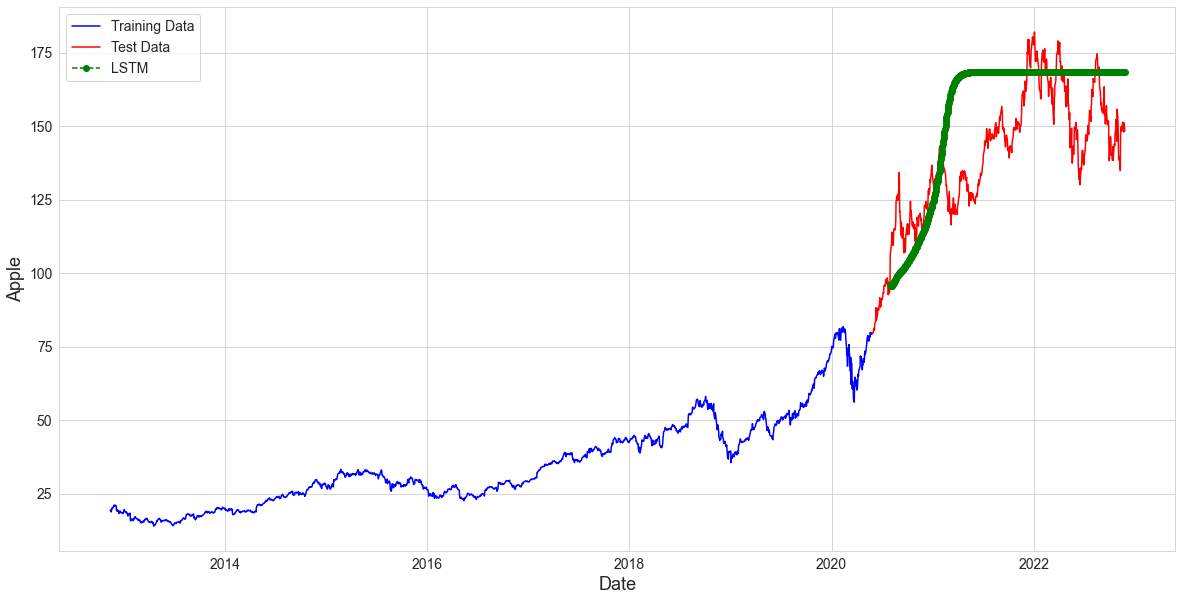

In [53]:
plt.figure(figsize=(20,10))


plt.plot(apple_raw.Date[:len_train], 
         apple_raw.Close[:len_train],
         'b',
         label="Training Data")


plt.plot(apple_raw.Date[len_train:], 
         apple_raw.Close[len_train:],
         'r',
         label="Test Data")


plt.plot(apple_raw.Date[len_train+window:], 
         LSTM_forecast[:,0],
         'g--o',
         label="LSTM")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Apple", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=2)

plt.show()

In [54]:
mse= mean_squared_error(apple_raw.Close[len_train+window:], LSTM_forecast[:,0])

In [55]:
mse

468.0911792800024

In [65]:
mape_lstm = mean_absolute_percentage_error(apple_raw.Close[len_train+window:], LSTM_forecast[:,0])
mape_lstm

0.13102829713443506

In [60]:
test_date_price = {'Date_test': apple_raw.Date[len_train+window:], 
                   'Price_test': apple_raw.Close[len_train+window:],
                   'Forecast_LSTM_add': LSTM_forecast[:,0].reshape(len(LSTM_forecast),)
                  }
df_test_LSTM_add = pd.DataFrame(data=test_date_price)

In [61]:
df_test_LSTM_add

,Date_test,Price_test,Forecast_LSTM_add
1941,2020-07-30,96.190002,96.086854
1942,2020-07-31,106.260002,95.891988
1943,2020-08-03,108.937500,95.759582
1944,2020-08-04,109.665001,95.701028
1945,2020-08-05,110.062500,95.718275
...,...,...,...
2523,2022-11-18,151.289993,168.452646
2524,2022-11-21,148.009995,168.452646
2525,2022-11-22,150.179993,168.452646
2526,2022-11-23,151.070007,168.452646


In [62]:
df_test_LSTM_add.to_csv('df_test_LSTM_add.csv', index=False)